# <font color='darkblue'> Part 4 : Similarity Network Fusion with Graph Convolutional Networks</font> 

In the previous notebook we trained a Graph Convolutional Network on two similarity matrices. We found that when our network is bad, our performance is bad. When we have a more informative network we can improve this performance. 

Neither of our networks were more expressive than performing a basic linear regression however. We are not fully leveraging the power of neworks, in particular their flexibility. 

In this notebook we will use the Similarity Network Fusion algorithm to integrate a second modality. 

In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from palettable import wesanderson
import snf
import sys
sys.path.insert(0 , './../')
from functions import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## <font color='darkblue'>Import and Process Generation Scotland Data</font>

In [2]:
with open('./../data/GCN_Data.pkl' , 'rb') as file : 
    loaded_data = pd.read_pickle(file)

In [3]:
phenotypes = loaded_data['phenotypes']

In [4]:
phenotypes

,Set,age,sex,bmi,units,usual,pack_years,started,stopped,Smoking
302425809462_R06C01,W1,32.949207,F,38.403319,15.172165,2.0,0.000000,NaN,NaN,Never
596230551484_R08C01,W1,51.997802,F,36.498110,2.389487,2.0,0.000000,NaN,NaN,Never
606527131238_R06C01,W1,59.737359,M,27.208886,10.398069,2.0,0.000000,NaN,NaN,Never
152513362107_R04C01,W1,61.404266,F,33.544477,1.620747,1.0,0.000000,NaN,NaN,Never
434374202209_R01C01,W1,69.057438,F,26.999401,NaN,NaN,0.000000,NaN,NaN,Never
...,...,...,...,...,...,...,...,...,...,...
654256527889_R03C01,W1,57.523495,M,36.525019,31.004204,1.0,154.504316,14.613231,0.000000,Smoker
156458444399_R07C01,W1,48.395640,F,30.182164,7.869285,2.0,26.087787,16.555785,NaN,Smoker
246344018115_R04C01,W1,53.952206,F,28.643913,0.000000,2.0,3.171329,16.881548,22.727996,Smoker
751983786989_R03C01,W1,49.447270,F,33.017533,0.000000,2.0,81.796032,19.247874,0.000000,Smoker


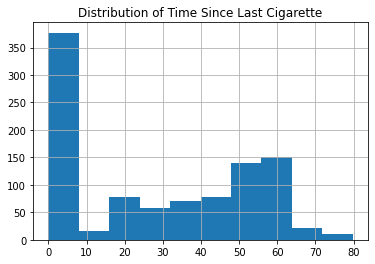

Never : 0 
Smoker : 1


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def time_since_last_smoked(row) : 
    if row['pack_years'] == 0 : 
        return row['age']
    else :
        if row.isna()['stopped'] : 
            return 0
        else : 
            return row['stopped']
        
phenotypes['time_since_last_smoked'] = phenotypes.apply(time_since_last_smoked , axis =1)

phenotypes['time_since_last_smoked'].hist()
plt.title('Distribution of Time Since Last Cigarette')
plt.show()

scaler = MinMaxScaler()
scaled_time = scaler.fit_transform(phenotypes[['time_since_last_smoked']]).reshape(1,-1)[0]

n = len(scaled_time)

# Create a DataFrame filled with zeros
df = pd.DataFrame(np.zeros((n, n)) , columns=phenotypes.index , index=phenotypes.index)

# Fill the DataFrame with the differences
for i, integer in enumerate(scaled_time):
    df.iloc[i, :] = 1 - np.abs(np.array(scaled_time) - integer)

df

node_colour = phenotypes['Smoking'].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

print(f"{phenotypes['Smoking'].astype('category').cat.categories[0]} : 0 \n{phenotypes['Smoking'].astype('category').cat.categories[1]} : 1")

G = plot_knn_network(df , 25 , phenotypes['Smoking'] , node_colours=node_colour)
plt.title('Time Since Last Cigarette Patient Similarity Network')
legend_handles = gen_graph_legend(node_colour , G , 'label')
plt.legend(handles = legend_handles)
plt.show()

## SNF

In [ ]:
G_time_to_smoke = G 
G_DNAm = loaded_data['PSN_EWAS']

In [ ]:
full_graphs = []

for graph in [G_time_to_smoke , G_DNAm] : 
    graph = nx.to_pandas_adjacency(graph)
    
    full_graphs.append(graph)

In [ ]:
k = 25
adj = snf.snf(full_graphs , K = k , t = 10)

adj_snf = pd.DataFrame(data=adj , index=phenotypes.index , columns=phenotypes.index)

node_colour = phenotypes.loc[adj_snf.index]['Smoking'].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

G = plot_knn_network(adj_snf, k , phenotypes['Smoking'] , node_colours=node_colour)
plt.title('Fused Patient Similarity Network')
legend_handles = gen_graph_legend(node_colour , G , 'label')
plt.legend(handles = legend_handles)
plt.show()

## Graph Convolutional Network

In [ ]:
from sklearn.model_selection import train_test_split
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch

g = dgl.from_networkx(G_time_to_smoke , node_attrs=['idx' , 'label'])
g.ndata['feat'] = torch.Tensor(loaded_data['Feat'].iloc[g.ndata['idx'].numpy()].values)

device = ('cuda' if torch.cuda.is_available() else 'cpu')

g = g.to(device)

node_subjects = phenotypes['Smoking'].iloc[g.ndata['idx'].detach().cpu().numpy()].reset_index(drop=True) # Get node target labels from meta data
node_subjects.name = 'Smoking'

train_tmp_index , test_index = train_test_split(
    node_subjects.index, train_size=0.6, stratify=node_subjects
    )
train_index , val_index = train_test_split(
    train_tmp_index, train_size=0.8, stratify=node_subjects.loc[train_tmp_index]
    )

GCN_input_shapes = g.ndata['feat'].shape[1]

labels = F.one_hot(g.ndata['label'].to(torch.int64))

output_metrics = []
logits = np.array([])
labels_all = np.array([])

model = GCN(GCN_input_shapes , [128 , 32], len(node_subjects.unique())).to(device) 
print(model)
print(g)

loss_plot = train(g, g.ndata['feat'] , train_index , val_index , device ,  model , labels , 2000 , 1e-3)
plt.show()

test_output_metrics = evaluate(test_index , device , g , g.ndata['feat'] , model , labels )

print(
    "GNN Model | Test Accuracy = {:.4f} | F1 = {:.4f} |".format(
     test_output_metrics[1] , test_output_metrics[2] )
)